In [13]:
import pandas as pd
import numpy as np 
import torch
import torch.nn  as nn
from torch.utils.data import DataLoader,Dataset
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter
import seaborn as sns

In [14]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [62]:
X,y = make_multilabel_classification(n_samples=10000,n_features=10,n_classes=3,n_labels=2)
X_torch = torch.FloatTensor(X)
y_torch = torch.FloatTensor(y)

In [63]:
X_train,X_test,y_train,y_test = train_test_split(X_torch,y_torch, test_size=0.2)

In [64]:
X_train.shape

torch.Size([8000, 10])

In [77]:
class MultiLabelData(Dataset):
    def __init__(self,X,y):
        self.X = X
        self.y = y
        self.len = self.X.shape[0]
    
    def __len__(self):
        return self.len
    
    def __getitem__(self,index):
        return self.X[index],self.y[index]

In [78]:
mutlilabel = MultiLabelData(X_train,y_train)
train_dataloader = DataLoader(MultiLabelData(X_train,y_train),batch_size=32,shuffle=True)
mutlilabel_test = MultiLabelData(X_test,y_test)
test_dataloader = DataLoader(MultiLabelData(X_test,y_test),batch_size=32,shuffle=True)

In [79]:
print(mutlilabel.X.shape)
print(mutlilabel.y.shape)
print(mutlilabel_test.X.shape)
print(mutlilabel_test.y.shape)

torch.Size([8000, 10])
torch.Size([8000, 3])
torch.Size([2000, 10])
torch.Size([2000, 3])


In [80]:
print(mutlilabel.y[10:20])

tensor([[1., 1., 1.],
        [0., 0., 0.],
        [0., 0., 1.],
        [0., 1., 1.],
        [0., 0., 1.],
        [1., 1., 0.],
        [1., 1., 0.],
        [0., 1., 1.],
        [0., 0., 1.],
        [0., 1., 0.]])


In [144]:
class MultiLabel(nn.Module):
    def __init__(self,input_size,output_size,hidden_layer):
        super(MultiLabel,self).__init__()
        self.l1 = nn.Linear(input_size,hidden_layer)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_layer,output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self,X):
        out1 = self.l1(X)
        out1 = self.relu(out1)
        out2 = self.l2(out1)
        final = self.sigmoid(out2)
        return final

In [145]:
input_dim = mutlilabel.X.shape[1]
output_dim = mutlilabel_test.y.shape[1]
hidden_layer = 20

In [146]:
model = MultiLabel(input_dim,output_dim,hidden_layer)

In [147]:
loss_fun = nn.BCEWithLogitsLoss()
LR = 0.01
optimizer = torch.optim.Adam(model.parameters(),lr=LR)

In [148]:
NUM_EPOCHS = 100
losses = []
for epoch in range(NUM_EPOCHS):
    for i, (X,y) in enumerate(train_dataloader):
        optimizer.zero_grad()

        y_pred = model(X)
        loss = loss_fun(y_pred,y)

        loss.backward()
        optimizer.step()

    losses.append(float(loss.data.detach().numpy()))
    if epoch%10 == 0:
        print(f"Epoch: {epoch}, Loss:{loss.data}")

Epoch: 0, Loss:0.5787571668624878
Epoch: 10, Loss:0.5787702202796936
Epoch: 20, Loss:0.5892292261123657
Epoch: 30, Loss:0.5359600186347961
Epoch: 40, Loss:0.574552059173584
Epoch: 50, Loss:0.5798413157463074
Epoch: 60, Loss:0.5958243012428284
Epoch: 70, Loss:0.5514962673187256
Epoch: 80, Loss:0.5574030876159668
Epoch: 90, Loss:0.5826190114021301


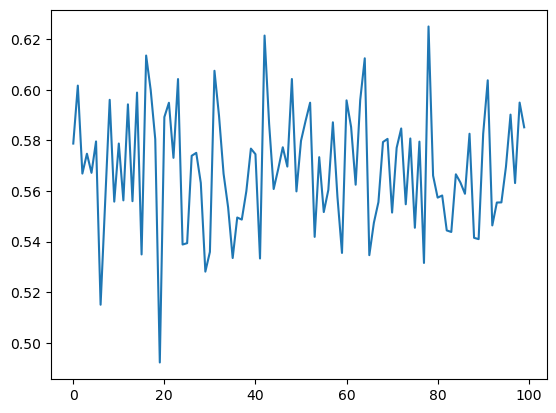

In [149]:
sns.lineplot(x=range(len(losses)),y=losses);

In [150]:
with torch.no_grad():
    y_pred_log = model(X_test).round()
    print(y_pred_log)

tensor([[0., 0., 0.],
        [1., 1., 1.],
        [0., 1., 1.],
        ...,
        [1., 1., 0.],
        [1., 1., 1.],
        [1., 1., 1.]])


In [151]:
y_test_str = [str(i) for i in y_test.detach().numpy()]
most_common_count = Counter(y_test_str).most_common()[0][1]

In [152]:
length = len(y_test_str)

In [153]:
print(type(most_common_count))
print(type(length))

<class 'int'>
<class 'int'>


In [154]:
print(f"Naive Classifier accuracy: {(most_common_count/length)*100}%")

Naive Classifier accuracy: 20.25%


In [155]:
accuracy_score(y_test,y_pred_log)

0.6125